# Emojify 
Here we are going to use word vector representation to build an Emojifier.
This can automatically turn this :
>"Congratulations on the promotion! Let's get coffee and talk. Love you!"

To this :

>"Congratulations on the promotion! 👍  Let's get coffee and talk. ☕️ Love you! ❤️"

### Using Word Vectors to Improve Emoji Lookups
* In many emoji interfaces, we need to remember that ❤️  is the "heart" symbol rather than the "love" symbol. 
    * In other words, we'll have to remember to type "heart" to find the desired emoji, and typing "love" won't bring up that symbol.
* we can make a more flexible emoji interface by using word vectors!
* When using word vectors, we'll see that even if our training set explicitly relates only a few words to a particular emoji, our algorithm will be able to generalize and associate additional words in the test set to the same emoji.
    * This works even if those additional words don't even appear in the training set. 
    * This allows we to build an accurate classifier mapping from sentences to emojis, even using a small training set. 

### What we'll build:
1. In this exercise, we'll start with a baseline model (Emojifier-V1) using word embeddings.
2. Then we will build a more sophisticated model (Emojifier-V2) that further incorporates an LSTM. 

### Packages

In [47]:
import numpy as np
from emo_utils import*
import emoji
import matplotlib.pyplot as plt
from test_utils import*



## Baseline Model: Emojifer-V1
### Dataset EMOJISET

Let's start by building a simple baseline classifier. 

We have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

<img src="images/data_set.png" style="width:700px;height:300px;">

In [2]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [3]:
X_train.shape

(132,)

In [4]:
X_test.shape

(56,)

In [5]:
maxLen = len(max(X_train, key=len).split())
maxLen

10

In [6]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again :disappointed:
I am proud of your achievements :smile:
It is the worst day in my life :disappointed:
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit :disappointed:
congratulations on your acceptance :smile:
The assignment is too long  :disappointed:
I want to go play ⚾


### Overview of the Emojifier-V1
<img src='./images/overview_of_v1.png'>

In [7]:
Y_oh_train = convert_to_one_hot(Y_train, C=5)
Y_oh_test = convert_to_one_hot(Y_test,C=5)

In [8]:
idx = 50
print(f"Sentence '{X_train[50]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


### Implementation of Emojifier-V1


In [9]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

We've loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
    - (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation. (50-dimensional)

In [10]:
word = "cucumber"
idx = 113317
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 113317th word in the vocabulary is cucumber


#### Implements `sentence_to_avg()`

In [11]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    any_word = list(word_to_vec_map.keys())[0]
    words = sentence.lower().split()
    l = 0
    avg = np.zeros(word_to_vec_map[any_word].shape)

    for w in words:
        if w in list(word_to_vec_map.keys()):
            avg += word_to_vec_map[w]
            l+=1
    
    if l > 0:
        avg = avg/l

    return avg

    

### Implements the Model
We now have all the pieces to finish implementing the `model()` function! 
After using `sentence_to_avg()` we need to:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

Implement the `model()` function described in Figure (2). 

* The equations you need to implement in the forward pass and to compute the cross-entropy cost are below:
* The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels. 

$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

**Note** : we will use loops to better understand the algorithm

In [12]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 200):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    any_word = list(word_to_vec_map.keys())[0]
    cost = 0
    m = Y.shape[0]
    n_y = len(np.unique(Y))
    n_h = word_to_vec_map[any_word].shape[0]

    W = np.random.rand(n_y, n_h) /np.sqrt(n_h)
    b = np.zeros((n_y,))

    Y_oh = convert_to_one_hot(Y,C=n_y)

    for t in range(num_iterations):
        for i in range(m):
            avg = sentence_to_avg(X[i],word_to_vec_map)
            
            #forward prop
            z = np.add(np.dot(W,avg),b)
            a = softmax(z)

            #cost
            cost = -np.sum(np.dot(Y_oh[i],np.log(a)))

            #backprop
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1),avg.reshape(1,n_h))
            db = dz 

            #update
            W = W - learning_rate * dW
            b = b - learning_rate * db 

            if i % 10 ==0:
                print("Epoch: " + str(t) + " --- cost = " + str(cost))
                pred = predict(X,Y,W,b,word_to_vec_map)
    

    return pred, W,b

        



In [77]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))


print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))

(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)
(132, 5)
<class 'numpy.ndarray'>


In [ ]:
np.random.seed(1)
pred , W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

### Examining Test Set Performance


In [18]:
print("Training Set")
pred_train = predict(X_train, Y_train, W,b, word_to_vec_map)
print("Test Set")
pred_test = predict(X_test, Y_test, W,b, word_to_vec_map)


Training Set
Accuracy: 0.9545454545454546
Test Set
Accuracy: 0.8571428571428571


In [19]:
def predict_single(sentence, W=W, b=b, word_to_vec_map=word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    any_words = list(word_to_vec_map.keys())[0]
    n_h = word_to_vec_map[any_words].shape[0]

    words = sentence.lower().split()
    
    avg = np.zeros((n_h,))
    count = 0
    for w in words:
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            count +=1 
    
    if count > 0:
        avg = avg/count

    Z = np.dot(W,avg) + b
    A = softmax(Z)
    pred = np.argmax(A)

    return pred

In [20]:
label_to_emoji(int(predict_single("let's play")))

'⚾'

let try with the word it has never seen before \
we will try with "I adore you" and "adore" didnot appear in the training set.

In [21]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol :smile:
lets play with a ball ⚾
food is ready 🍴
not feeling happy :smile:


#### Word Ordering isn't Considered in this Model
* Note that the model doesn't get the following sentence correct:
>"not feeling happy" 

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy

### Confusion Matrix
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

(56,)
           ❤️    ⚾    :smile:    :disappointed:   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


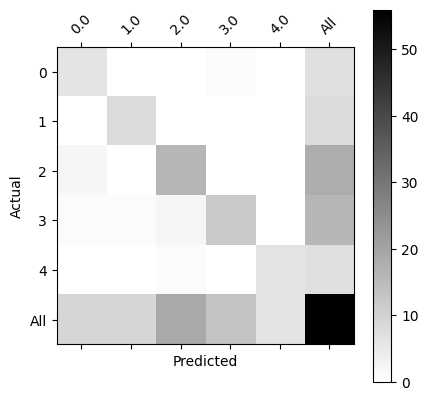

In [22]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

# Emojifier-V2: Using LSTMs in keras
We are going to buld an LSTM model that takes word sequences as input. This model will be able to account for word ordering.


### Packages

In [42]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Input,Dropout,LSTM, Activation
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.preprocessing import sequence 
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(0)


### Model Overview
<img src='./images/lstm_seq.png'>

#### Padding
Here we want to train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the same length.

**Padding Handles Sequences of Varying Length**\
- The common solution to handling sequences of different length is to use padding. Specifically:
    - Set a maximum sequence length
    - Pad all sequences to have the same length.


#### Embedding()
**Inputs and Outputs to the Embedding Layer**

* The `Embedding()` layer's input is an integer matrix of size **(batch size, max input length)**. 
    * This input corresponds to sentences converted into lists of indices (integers).
    * The largest integer (the highest word index) in the input should be no larger than the vocabulary size.
* The embedding layer outputs an array of shape (batch size, max input length, dimension of word vectors).

* The figure shows the propagation of two example sentences through the embedding layer. 
    * Both examples have been zero-padded to a length of `max_len=5`.
    * The word embeddings are 50 units in length.
    * The final dimension of the representation is  `(2,max_len,50)`. 

<img src="images/embedding1.png" style="width:700px;height:250px;">
<caption><center><font color='white'> Embedding layer</center></caption>

Implements `sentences_to_indices`

This function processes an array of sentences X and returns inputs to the embedding layer:

In [31]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    m = X.shape[0]
    X_indices = np.zeros([m,max_len])
    

    for i in range(m):

        j = 0
        sentence_words = X[i].lower().split()

        for w in sentence_words:
            if w in word_to_index:
                X_indices[i,j] = word_to_index[w]
                j+=1

    return X_indices 


In [33]:

X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


### Building Embedding Layer 
This is a layer that takes word indices and returns word embedding for a sentences.

In [35]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_size = len(word_to_index) + 1
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]
    emb_matix = np.zeros([vocab_size,emb_dim])

    for word, idx in word_to_index.items():
        emb_matix[idx,:]= word_to_vec_map[word]

    embedding_layer = Embedding(input_dim=vocab_size, output_dim=emb_dim,trainable = False)

    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matix])

    return embedding_layer 


### Building the Emojifier-V2
<img src='images/lstm_seq_full.png'>

### Building the Emojifier-V2
#### Additional Hints
* Remember that these Keras layers return an object, and we will feed in the outputs of the previous layer as the input arguments to that object.  The returned object can be created and called in the same line.

```Python
# How to use Keras layers in two lines of code
dense_object = Dense(units = ...)
X = dense_object(inputs)

# How to use Keras layers in one line of code
X = Dense(units = ...)(inputs)
```

In [53]:

def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    sentence_indices = Input(shape=input_shape,dtype='int32')
    embedded_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embedding = embedded_layer(sentence_indices)
    X = LSTM(units=128,return_sequences=True)(embedding)
    X = Dropout(0.5)(X)
    X = LSTM(units=128,return_sequences=False)(X)
    X = Dropout(0.5)(X)
    X = Dense(5)(X)
    X = Activation("softmax")(X)

    model = Model(inputs=sentence_indices,outputs=X)

    return model
     
    

In [55]:
model = Emojify_V2((maxLen,), word_to_vec_map,word_to_index)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 10, 50)         │    20,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 10, 128)        │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,223,927 (77.15 MB)

 Trainable params: 223,877 (874.52 KB)

 Non-trainable params: 20,000,050 (76.29 MB)

In [56]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#### Training

In [58]:
X_train_indices = sentences_to_indices(X_train,word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train,C=5)
model.fit(X_train_indices,Y_train_oh,epochs=100,batch_size=32,shuffle=True)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.2631 - loss: 1.5947
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3996 - loss: 1.5069
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3098 - loss: 1.4844
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4126 - loss: 1.3495
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6402 - loss: 1.2108
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6670 - loss: 1.0701
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6108 - loss: 0.9467
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7191 - loss: 0.8411
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7136 - loss: 0.7728
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7536 - loss: 0.7049
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7644 - loss: 0.5777
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7426 - lo

In [59]:
X_test_indices = sentences_to_indices(X_test,word_to_index,maxLen)
Y_test_oh = convert_to_one_hot(Y_test,C=5)
loss, acc = model.evaluate(X_test_indices,Y_oh_test)
print()
print("Test Accuracy",acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7976 - loss: 0.6578 

Test Accuracy 0.8214285969734192


In [60]:
# This code allows to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Expected emoji::smile: prediction: she got me a nice present	❤️
Expected emoji::disappointed: prediction: work is hard	:smile:
Expected emoji::disappointed: prediction: This girl is messing with me	❤️
Expected emoji::disappointed: prediction: work is horrible	:smile:
Expected emoji:🍴 prediction: any suggestions for dinner	:smile:
Expected emoji:❤️ prediction: I love taking breaks	:disappointed:
Expected emoji::smile: prediction: you brighten my day	❤️
Expected emoji::disappointed: prediction: she is a bully	❤️
Expected emoji::disappointed: prediction: My life is so boring	❤️
Expected emoji::disappointed: prediction: go away	⚾


Now we can try with our sentences

In [69]:
x_test = np.array(["not feeling happy"])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
not feeling happy :disappointed:


In [75]:
x_test = np.array(["We have completed it, now let's  eat"])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
We have completed it, now let's  eat 🍴


 ### References
 Deep learning specialization : https://www.coursera.org/specializations/deep-learning